In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm

In [1]:
!curl -L -o deep-fake-detection-dfd-entire-original-dataset.zip\
  https://www.kaggle.com/api/v1/datasets/download/sanikatiwarekar/deep-fake-detection-dfd-entire-original-dataset

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 22.4G  100 22.4G    0     0  17.7M      0  0:21:36  0:21:36 --:--:-- 16.9M      0  0:21:41  0:06:05  0:15:36 19.3M  17.8M      0  0:21:33  0:07:20  0:14:13 18.7M8  0:10:46  0:10:32 18.7M     0  17.7M      0  0:21:36  0:20:55  0:00:41 19.0M


In [2]:
!unzip deep-fake-detection-dfd-entire-original-dataset.zip

Archive:  deep-fake-detection-dfd-entire-original-dataset.zip
  inflating: DFD_manipulated_sequences/DFD_manipulated_sequences/01_02__exit_phone_room__YVGY8LOK.mp4  
  inflating: DFD_manipulated_sequences/DFD_manipulated_sequences/01_02__hugging_happy__YVGY8LOK.mp4  
  inflating: DFD_manipulated_sequences/DFD_manipulated_sequences/01_02__meeting_serious__YVGY8LOK.mp4  
  inflating: DFD_manipulated_sequences/DFD_manipulated_sequences/01_02__outside_talking_still_laughing__YVGY8LOK.mp4  
  inflating: DFD_manipulated_sequences/DFD_manipulated_sequences/01_02__secret_conversation__YVGY8LOK.mp4  
  inflating: DFD_manipulated_sequences/DFD_manipulated_sequences/01_02__talking_against_wall__YVGY8LOK.mp4  
  inflating: DFD_manipulated_sequences/DFD_manipulated_sequences/01_02__talking_angry_couch__YVGY8LOK.mp4  
  inflating: DFD_manipulated_sequences/DFD_manipulated_sequences/01_02__walk_down_hall_angry__YVGY8LOK.mp4  
  inflating: DFD_manipulated_sequences/DFD_manipulated_sequences/01_02__wal

In [ ]:
!mv DFD_original\ sequences real

In [4]:
!mv DFD_manipulated_sequences/DFD_manipulated_sequences/ fake/

## Extracting frames from video

In [ ]:
real_videos_dir = "real/"
manipulated_videos_dir = "fake/"

output_real_dir = "frames/real/"
output_manipulated_dir = "frames/fake/"
os.makedirs(output_real_dir, exist_ok=True)
os.makedirs(output_manipulated_dir, exist_ok=True)

In [ ]:
import cv2
def extract_frames_from_videos(videos_dir, output_dir, label):
    video_files = [f for f in os.listdir(videos_dir) if f.endswith(('.mp4', '.avi', '.mov', '.mkv'))]

    for video_file in tqdm(video_files):
        video_path = os.path.join(videos_dir, video_file)
        cap = cv2.VideoCapture(video_path)
        frame_count = 0
        success, image = cap.read()

        while success:
            if frame_count % int(cap.get(cv2.CAP_PROP_FPS)) == 0:
                frame_filename = f"{label}_{video_file}_frame{frame_count // int(cap.get(cv2.CAP_PROP_FPS))}.jpg"
                frame_path = os.path.join(output_dir, frame_filename)
                cv2.imwrite(frame_path, image)
            success, image = cap.read()
            frame_count += 1

        cap.release()


In [ ]:
extract_frames_from_videos(real_videos_dir, output_real_dir, "real")
extract_frames_from_videos(manipulated_videos_dir, output_manipulated_dir, "manipulated")

## Extract faces from frames

In [3]:
from mtcnn import MTCNN
from pathlib import Path
import cv2
import lz4

detector = MTCNN()

input_dirs = ["frames/fake", "frames/real"]
output_base = "faces"
margin = 40  

for label in ['fake', 'real']:
    os.makedirs(os.path.join(output_base, label), exist_ok=True)

def extract_face_with_margin(image, box, margin=40):
    h, w, _ = image.shape
    x, y, width, height = box
    x1 = max(x - margin, 0)
    y1 = max(y - margin, 0)
    x2 = min(x + width + margin, w)
    y2 = min(y + height + margin, h)
    return image[y1:y2, x1:x2]

for label in ['fake', 'real']:
    input_path = Path(f"frames/{label}")
    output_path = Path(f"faces/{label}")
    
    for img_file in input_path.glob("*.jpg"):
        img = cv2.imread(str(img_file))
        if img is None:
            print(f"Warning: could not read {img_file}")
            continue

        rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        results = detector.detect_faces(rgb_img)

        for idx, result in enumerate(results):
            if result['confidence'] < 0.90:
                continue

            face_crop = extract_face_with_margin(img, result['box'], margin=margin)

            out_filename = output_path / f"{img_file.stem}_face{idx}.jpg"
            cv2.imwrite(str(out_filename), face_crop)
            print(f"Saved: {out_filename}")


Saved: faces/fake/manipulated_27_06__hugging_happy__S3T7SK9O.mp4_frame26_face0.jpg
Saved: faces/fake/manipulated_14_13__talking_against_wall__KMQ3AW6A.mp4_frame4_face0.jpg
Saved: faces/fake/manipulated_14_20__talking_angry_couch__R7SPX6OK.mp4_frame13_face0.jpg
Saved: faces/fake/manipulated_11_03__outside_talking_still_laughing__P08VGHTA.mp4_frame1_face0.jpg
Saved: faces/fake/manipulated_18_11__talking_against_wall__PT4YKO2R.mp4_frame13_face0.jpg
Saved: faces/fake/manipulated_24_19__podium_speech_happy__OF8LF68K.mp4_frame42_face0.jpg
Saved: faces/fake/manipulated_21_14__talking_angry_couch__N0WM4GSV.mp4_frame12_face0.jpg
Saved: faces/fake/manipulated_03_06__walking_down_street_outside_angry__1IXGY2FK.mp4_frame26_face0.jpg
Saved: faces/fake/manipulated_20_18__hugging_happy__8BMQOD7S.mp4_frame6_face0.jpg
Saved: faces/fake/manipulated_01_11__outside_talking_still_laughing__4OJNJLOO.mp4_frame4_face0.jpg
Saved: faces/fake/manipulated_14_13__talking_against_wall__KMQ3AW6A.mp4_frame28_face0.jp

2025-06-10 17:15:01.585059: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: INVALID_ARGUMENT: Incompatible shapes: [0,48,48,3] vs. [1,1,1,32]


Saved: faces/fake/manipulated_12_11__talking_against_wall__8NS148U7.mp4_frame23_face0.jpg
Saved: faces/fake/manipulated_21_14__talking_angry_couch__N0WM4GSV.mp4_frame46_face0.jpg
Saved: faces/fake/manipulated_21_14__talking_angry_couch__N0WM4GSV.mp4_frame46_face1.jpg
Saved: faces/fake/manipulated_23_22__secret_conversation__10R2HRAU.mp4_frame20_face0.jpg
Saved: faces/fake/manipulated_23_22__secret_conversation__10R2HRAU.mp4_frame20_face1.jpg
Saved: faces/fake/manipulated_01_03__talking_against_wall__JZUXXFRB.mp4_frame32_face0.jpg
Saved: faces/fake/manipulated_02_09__meeting_serious__9TDCEK1Q.mp4_frame13_face0.jpg
Saved: faces/fake/manipulated_02_09__meeting_serious__9TDCEK1Q.mp4_frame13_face1.jpg
Saved: faces/fake/manipulated_02_09__meeting_serious__9TDCEK1Q.mp4_frame13_face2.jpg
Saved: faces/fake/manipulated_19_22__talking_against_wall__VK6BF5NV.mp4_frame7_face0.jpg
Saved: faces/fake/manipulated_22_19__walking_down_indoor_hall_disgust__VK6BF5NV.mp4_frame7_face0.jpg
Saved: faces/fake/m

2025-06-10 17:22:48.552188: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: INVALID_ARGUMENT: Incompatible shapes: [0,48,48,3] vs. [1,1,1,32]


Saved: faces/fake/manipulated_27_02__walking_and_outside_surprised__QW05XUUZ.mp4_frame35_face0.jpg
Saved: faces/fake/manipulated_27_02__walking_and_outside_surprised__QW05XUUZ.mp4_frame35_face1.jpg
Saved: faces/fake/manipulated_27_02__walking_and_outside_surprised__QW05XUUZ.mp4_frame35_face2.jpg
Saved: faces/fake/manipulated_07_25__hugging_happy__IKMKYKPG.mp4_frame2_face0.jpg
Saved: faces/fake/manipulated_02_01__meeting_serious__YVGY8LOK.mp4_frame11_face0.jpg
Saved: faces/fake/manipulated_02_01__meeting_serious__YVGY8LOK.mp4_frame11_face1.jpg
Saved: faces/fake/manipulated_02_01__meeting_serious__YVGY8LOK.mp4_frame11_face2.jpg
Saved: faces/fake/manipulated_21_07__talking_against_wall__CRGVSDBI.mp4_frame7_face0.jpg
Saved: faces/fake/manipulated_27_02__podium_speech_happy__6GC9HY9J.mp4_frame29_face0.jpg
Saved: faces/fake/manipulated_02_18__walking_down_street_outside_angry__21JTDDEL.mp4_frame19_face0.jpg
Saved: faces/fake/manipulated_02_15__walking_and_outside_surprised__HTG660F8.mp4_fram

2025-06-10 19:55:40.780645: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: INVALID_ARGUMENT: Incompatible shapes: [0,48,48,3] vs. [1,1,1,32]


Saved: faces/real/real_26__podium_speech_happy.mp4_frame4_face0.jpg
Saved: faces/real/real_13__hugging_happy.mp4_frame10_face0.jpg
Saved: faces/real/real_28__podium_speech_happy.mp4_frame14_face0.jpg
Saved: faces/real/real_24__walking_down_street_outside_angry.mp4_frame19_face0.jpg
Saved: faces/real/real_24__walk_down_hall_angry.mp4_frame12_face0.jpg
Saved: faces/real/real_03__walking_outside_cafe_disgusted.mp4_frame27_face0.jpg
Saved: faces/real/real_22__outside_talking_pan_laughing.mp4_frame1_face0.jpg
Saved: faces/real/real_20__kitchen_pan.mp4_frame14_face0.jpg
Saved: faces/real/real_22__walking_down_indoor_hall_disgust.mp4_frame39_face0.jpg
Saved: faces/real/real_22__walking_down_indoor_hall_disgust.mp4_frame39_face1.jpg
Saved: faces/real/real_15__outside_talking_pan_laughing.mp4_frame26_face0.jpg
Saved: faces/real/real_12__walking_down_street_outside_angry.mp4_frame23_face0.jpg
Saved: faces/real/real_14__talking_against_wall.mp4_frame36_face0.jpg
Saved: faces/real/real_20__secret_

2025-06-10 20:33:36.300227: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: INVALID_ARGUMENT: Incompatible shapes: [0,48,48,3] vs. [1,1,1,32]


Saved: faces/real/real_14__exit_phone_room.mp4_frame3_face0.jpg
Saved: faces/real/real_11__talking_angry_couch.mp4_frame45_face0.jpg
Saved: faces/real/real_01__talking_angry_couch.mp4_frame16_face0.jpg
Saved: faces/real/real_08__outside_talking_still_laughing.mp4_frame2_face0.jpg
Saved: faces/real/real_08__kitchen_still.mp4_frame18_face0.jpg
Saved: faces/real/real_16__outside_talking_pan_laughing.mp4_frame5_face0.jpg
Saved: faces/real/real_16__outside_talking_pan_laughing.mp4_frame5_face1.jpg
Saved: faces/real/real_08__outside_talking_still_laughing.mp4_frame25_face0.jpg
Saved: faces/real/real_23__walking_down_street_outside_angry.mp4_frame52_face0.jpg
Saved: faces/real/real_11__secret_conversation.mp4_frame37_face0.jpg
Saved: faces/real/real_11__secret_conversation.mp4_frame37_face1.jpg
Saved: faces/real/real_14__walking_and_outside_surprised.mp4_frame16_face0.jpg
Saved: faces/real/real_14__walking_and_outside_surprised.mp4_frame16_face1.jpg
Saved: faces/real/real_16__talking_against_

2025-06-10 21:26:57.280160: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: INVALID_ARGUMENT: Incompatible shapes: [0,48,48,3] vs. [1,1,1,32]


Saved: faces/real/real_22__outside_talking_pan_laughing.mp4_frame18_face0.jpg
Saved: faces/real/real_01__walking_down_indoor_hall_disgust.mp4_frame20_face0.jpg
Saved: faces/real/real_01__walking_down_indoor_hall_disgust.mp4_frame20_face1.jpg
Saved: faces/real/real_22__walking_and_outside_surprised.mp4_frame34_face0.jpg
Saved: faces/real/real_22__walking_and_outside_surprised.mp4_frame34_face1.jpg
Saved: faces/real/real_01__secret_conversation.mp4_frame6_face0.jpg
Saved: faces/real/real_01__secret_conversation.mp4_frame6_face1.jpg
Saved: faces/real/real_24__exit_phone_room.mp4_frame16_face0.jpg
Saved: faces/real/real_11__talking_against_wall.mp4_frame19_face0.jpg
Saved: faces/real/real_27__walking_down_street_outside_angry.mp4_frame13_face0.jpg
Saved: faces/real/real_22__secret_conversation.mp4_frame6_face0.jpg
Saved: faces/real/real_09__outside_talking_pan_laughing.mp4_frame25_face0.jpg
Saved: faces/real/real_12__walking_and_outside_surprised.mp4_frame20_face0.jpg
Saved: faces/real/rea

2025-06-10 22:31:22.189846: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: INVALID_ARGUMENT: Incompatible shapes: [0,48,48,3] vs. [1,1,1,32]


Saved: faces/real/real_03__kitchen_still.mp4_frame32_face0.jpg
Saved: faces/real/real_19__outside_talking_still_laughing.mp4_frame27_face0.jpg
Saved: faces/real/real_19__talking_angry_couch.mp4_frame25_face0.jpg
Saved: faces/real/real_22__podium_speech_happy.mp4_frame28_face0.jpg
Saved: faces/real/real_18__kitchen_pan.mp4_frame30_face0.jpg
Saved: faces/real/real_10__talking_against_wall.mp4_frame42_face0.jpg
Saved: faces/real/real_08__walking_down_street_outside_angry.mp4_frame18_face0.jpg
Saved: faces/real/real_03__walking_down_indoor_hall_disgust.mp4_frame10_face0.jpg
Saved: faces/real/real_03__walking_down_indoor_hall_disgust.mp4_frame10_face1.jpg
Saved: faces/real/real_03__walking_down_indoor_hall_disgust.mp4_frame10_face2.jpg
Saved: faces/real/real_11__secret_conversation.mp4_frame38_face0.jpg
Saved: faces/real/real_26__podium_speech_happy.mp4_frame35_face0.jpg
Saved: faces/real/real_19__talking_angry_couch.mp4_frame34_face0.jpg
Saved: faces/real/real_09__podium_speech_happy.mp4_f

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data_dir = "faces"
batch_size = 32
img_size = 224
num_epochs = 10


## Data Transformations

In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((img_size + 10, img_size + 10)),
        transforms.RandomResizedCrop(img_size, scale=(0.9, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'val': transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
}

In [12]:
dataset = datasets.ImageFolder(data_dir, transform=data_transforms['train'])
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=12, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=12, pin_memory=True)

def train_model(model, criterion, optimizer, num_epochs=10, name="pretrained", scheduler=None):
    model.to(device)
    train_acc_history = []
    val_acc_history = []
    train_loss_history = []
    best_val_acc = 0
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 30)
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in tqdm(train_loader, desc="Training"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        val_acc = evaluate(model)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), f"{name}_model_best.pth")
        if scheduler:
            scheduler.step()
        train_acc_history.append(train_acc)
        val_acc_history.append(val_acc)
        train_loss_history.append(train_loss)

        print(f"Train Loss: {train_loss:.4f}")
        print(f"Train Accuracy: {train_acc:.4f}")
        print(f"Validation Accuracy: {val_acc:.4f}")

    return model, train_acc_history, val_acc_history, train_loss_history

def evaluate(model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    return correct / total


In [13]:
import matplotlib.pyplot as plt

def plot_metrics(train_acc, val_acc, train_loss):
    epochs = range(1, len(train_acc) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, label='Train Accuracy')
    plt.plot(epochs, val_acc, label='Val Accuracy')
    plt.title('Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, label='Train Loss')
    plt.title('Training Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [ ]:
from typing import Optional, Callable, Union
from torch import Tensor

def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        groups=groups,
        bias=False,
        dilation=dilation,
    )


def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion: int = 1

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError("BasicBlock only supports groups=1 and base_width=64")
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):
    def __init__(
        self,
        block: BasicBlock,
        layers: list[int],
        num_classes: int = 1000,
        zero_init_residual: bool = False,
        groups: int = 1,
        width_per_group: int = 64,
        replace_stride_with_dilation: Optional[list[bool]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError(
                "replace_stride_with_dilation should be None "
                f"or a 3-element tuple, got {replace_stride_with_dilation}"
            )
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, BasicBlock) and m.bn2.weight is not None:
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]

    def _make_layer(
        self,
        block: BasicBlock,
        planes: int,
        blocks: int,
        stride: int = 1,
        dilate: bool = False,
    ) -> nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(
            block(
                self.inplanes, planes, stride, downsample, self.groups, self.base_width, previous_dilation, norm_layer
            )
        )
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    groups=self.groups,
                    base_width=self.base_width,
                    dilation=self.dilation,
                    norm_layer=norm_layer,
                )
            )

        return nn.Sequential(*layers)

    def _forward_impl(self, x: Tensor) -> Tensor:
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)


def resnet18_scratch(num_classes):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes)

In [15]:
from torch.optim.lr_scheduler import StepLR
scratch_model = resnet18_scratch(num_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(scratch_model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = StepLR(optimizer, step_size=3, gamma=0.5)

In [16]:
print("Training ResNet18 from scratch (custom implementation)...")
scratch_model, scratch_train_acc, scratch_val_acc, scratch_loss = train_model(scratch_model, criterion, optimizer, num_epochs, "scratch", scheduler)

Training ResNet18 from scratch (custom implementation)...

Epoch 1/10
------------------------------


100%|██████████| 198/198 [00:07<00:00, 25.18it/s]


Train Loss: 0.6555
Train Accuracy: 0.6076
Validation Accuracy: 0.6107

Epoch 2/10
------------------------------


100%|██████████| 198/198 [00:08<00:00, 22.39it/s]


Train Loss: 0.5576
Train Accuracy: 0.7124
Validation Accuracy: 0.7039

Epoch 3/10
------------------------------


100%|██████████| 198/198 [00:07<00:00, 25.11it/s]


Train Loss: 0.4860
Train Accuracy: 0.7643
Validation Accuracy: 0.7728

Epoch 4/10
------------------------------


100%|██████████| 198/198 [00:07<00:00, 25.22it/s]


Train Loss: 0.4035
Train Accuracy: 0.8082
Validation Accuracy: 0.8071

Epoch 5/10
------------------------------


100%|██████████| 198/198 [00:07<00:00, 25.07it/s]


Train Loss: 0.3745
Train Accuracy: 0.8283
Validation Accuracy: 0.7694

Epoch 6/10
------------------------------


100%|██████████| 198/198 [00:07<00:00, 25.00it/s]


Train Loss: 0.3566
Train Accuracy: 0.8366
Validation Accuracy: 0.8287

Epoch 7/10
------------------------------


100%|██████████| 198/198 [00:07<00:00, 25.06it/s]


Train Loss: 0.3093
Train Accuracy: 0.8546
Validation Accuracy: 0.8485

Epoch 8/10
------------------------------


100%|██████████| 198/198 [00:07<00:00, 24.96it/s]


Train Loss: 0.2916
Train Accuracy: 0.8665
Validation Accuracy: 0.8625

Epoch 9/10
------------------------------


100%|██████████| 198/198 [00:07<00:00, 25.07it/s]


Train Loss: 0.2768
Train Accuracy: 0.8700
Validation Accuracy: 0.8682

Epoch 10/10
------------------------------


100%|██████████| 198/198 [00:07<00:00, 25.05it/s]


Train Loss: 0.2536
Train Accuracy: 0.8806
Validation Accuracy: 0.8767


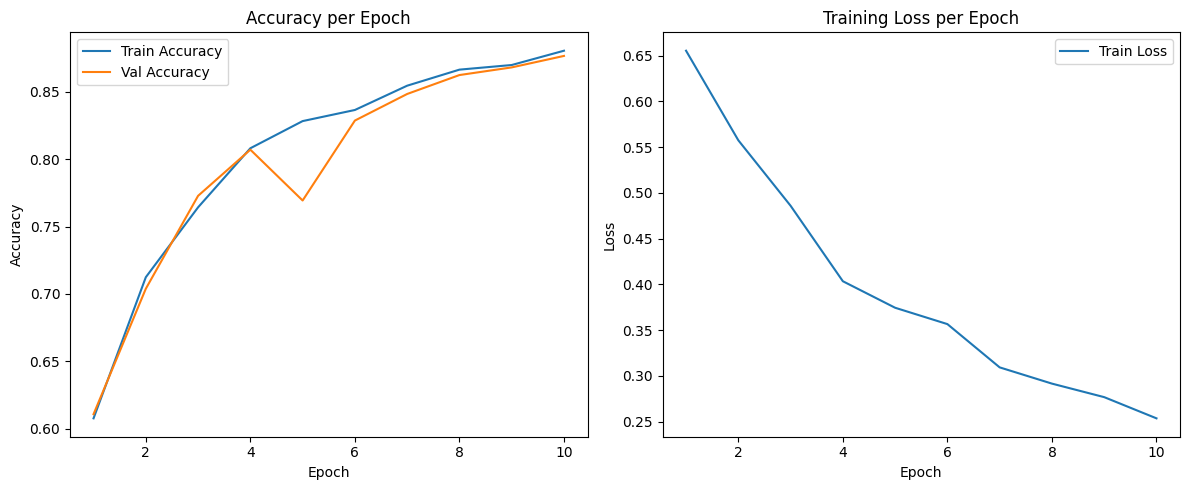

In [17]:
plot_metrics(scratch_train_acc, scratch_val_acc, scratch_loss)

In [18]:
pretrained_model = models.resnet18(pretrained=True)
pretrained_model.fc = nn.Linear(pretrained_model.fc.in_features, 2)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(pretrained_model.parameters(), lr=1e-4)

print("Training pretrained ResNet...")
pretrained_model, pretrained_train_acc, pretrained_val_acc, pretrained_loss = train_model(pretrained_model, criterion, optimizer, num_epochs)

/home/yuki/env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/yuki/env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/yuki/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:06<00:00, 6.71MB/s]


Training pretrained ResNet...

Epoch 1/10
------------------------------


100%|██████████| 198/198 [00:07<00:00, 25.17it/s]


Train Loss: 0.3461
Train Accuracy: 0.8333
Validation Accuracy: 0.8758

Epoch 2/10
------------------------------


100%|██████████| 198/198 [00:07<00:00, 24.94it/s]


Train Loss: 0.2411
Train Accuracy: 0.8856
Validation Accuracy: 0.8991

Epoch 3/10
------------------------------


100%|██████████| 198/198 [00:07<00:00, 24.77it/s]


Train Loss: 0.2090
Train Accuracy: 0.8979
Validation Accuracy: 0.8545

Epoch 4/10
------------------------------


100%|██████████| 198/198 [00:07<00:00, 25.16it/s]


Train Loss: 0.1937
Train Accuracy: 0.9027
Validation Accuracy: 0.8930

Epoch 5/10
------------------------------


100%|██████████| 198/198 [00:07<00:00, 24.77it/s]


Train Loss: 0.1875
Train Accuracy: 0.9065
Validation Accuracy: 0.8991

Epoch 6/10
------------------------------


100%|██████████| 198/198 [00:08<00:00, 24.69it/s]


Train Loss: 0.1800
Train Accuracy: 0.9101
Validation Accuracy: 0.8987

Epoch 7/10
------------------------------


100%|██████████| 198/198 [00:07<00:00, 24.77it/s]


Train Loss: 0.1714
Train Accuracy: 0.9154
Validation Accuracy: 0.9020

Epoch 8/10
------------------------------


100%|██████████| 198/198 [00:07<00:00, 25.02it/s]


Train Loss: 0.1666
Train Accuracy: 0.9162
Validation Accuracy: 0.9073

Epoch 9/10
------------------------------


100%|██████████| 198/198 [00:13<00:00, 14.47it/s]


Train Loss: 0.1634
Train Accuracy: 0.9180
Validation Accuracy: 0.9053

Epoch 10/10
------------------------------


100%|██████████| 198/198 [00:07<00:00, 24.85it/s]


Train Loss: 0.1597
Train Accuracy: 0.9182
Validation Accuracy: 0.9075


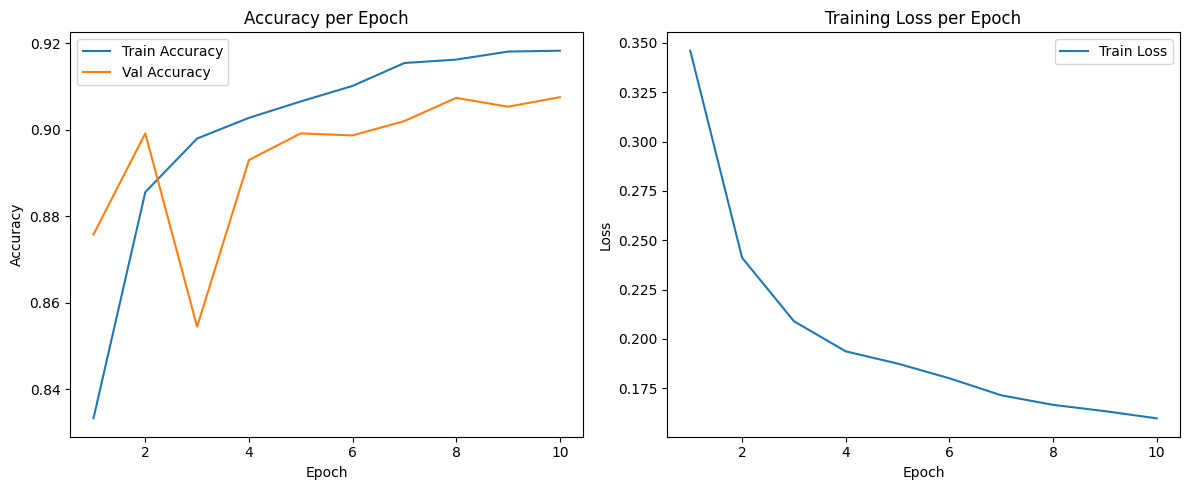

In [19]:
plot_metrics(pretrained_train_acc, pretrained_val_acc, pretrained_loss)

In [20]:
import optuna

def objective(trial):
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)
    dropout_fc = trial.suggest_uniform('dropout_fc', 0.2, 0.7)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-2)

    model = models.resnet18(pretrained=True)
    num_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_features, 256),
        nn.ReLU(inplace=True),
        nn.Dropout(p=dropout_fc),
        nn.Linear(256, 2)
    )
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    num_trial_epochs = 3
    for epoch in range(num_trial_epochs):
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    return evaluate(model)


In [21]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5) 

[I 2025-06-11 00:51:56,973] A new study created in memory with name: no-name-9f7221e6-acbc-4f6d-803d-c0ba6e3a7d7a
/tmp/ipykernel_108387/2780269729.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)
/tmp/ipykernel_108387/2780269729.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_fc = trial.suggest_uniform('dropout_fc', 0.2, 0.7)
/tmp/ipykernel_108387/2780269729.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-

In [22]:
import optuna.visualization as vis

vis.plot_param_importances(study).show()

In [23]:
print("Best trial:")
trial = study.best_trial

for key, value in trial.params.items():
    print(f"  {key}: {value}")

best_model = models.resnet18(pretrained=True)
best_model.fc = nn.Sequential(
    nn.Linear(best_model.fc.in_features, 256),
    nn.ReLU(inplace=True),
    nn.Dropout(p=trial.params['dropout_fc']),
    nn.Linear(256, 2)
)
best_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(best_model.parameters(), lr=trial.params['lr'], weight_decay=trial.params['weight_decay'])

print("Retraining best model...")
best_model, best_model_train_acc, best_model_val_acc, best_model_loss = train_model(best_model, criterion, optimizer, num_epochs=10)

Best trial:
  lr: 2.2712967165321645e-05
  dropout_fc: 0.3179147237768531
  weight_decay: 2.2530307843567653e-06


/home/yuki/env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/home/yuki/env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.



Retraining best model...

Epoch 1/10
------------------------------


100%|██████████| 198/198 [00:08<00:00, 24.70it/s]


Train Loss: 0.4081
Train Accuracy: 0.8031
Validation Accuracy: 0.8707

Epoch 2/10
------------------------------


100%|██████████| 198/198 [00:07<00:00, 24.92it/s]


Train Loss: 0.2637
Train Accuracy: 0.8782
Validation Accuracy: 0.8718

Epoch 3/10
------------------------------


100%|██████████| 198/198 [00:08<00:00, 24.62it/s]


Train Loss: 0.2224
Train Accuracy: 0.8927
Validation Accuracy: 0.8950

Epoch 4/10
------------------------------


100%|██████████| 198/198 [00:07<00:00, 24.82it/s]


Train Loss: 0.2081
Train Accuracy: 0.8987
Validation Accuracy: 0.9018

Epoch 5/10
------------------------------


100%|██████████| 198/198 [00:08<00:00, 24.61it/s]


Train Loss: 0.1894
Train Accuracy: 0.9063
Validation Accuracy: 0.8998

Epoch 6/10
------------------------------


100%|██████████| 198/198 [00:08<00:00, 24.69it/s]


Train Loss: 0.1809
Train Accuracy: 0.9097
Validation Accuracy: 0.9021

Epoch 7/10
------------------------------


100%|██████████| 198/198 [00:10<00:00, 19.16it/s]


Train Loss: 0.1724
Train Accuracy: 0.9129
Validation Accuracy: 0.9039

Epoch 8/10
------------------------------


100%|██████████| 198/198 [00:16<00:00, 12.26it/s]


Train Loss: 0.1695
Train Accuracy: 0.9161
Validation Accuracy: 0.8976

Epoch 9/10
------------------------------


100%|██████████| 198/198 [00:07<00:00, 25.18it/s]


Train Loss: 0.1589
Train Accuracy: 0.9186
Validation Accuracy: 0.9066

Epoch 10/10
------------------------------


100%|██████████| 198/198 [00:07<00:00, 24.90it/s]


Train Loss: 0.1570
Train Accuracy: 0.9209
Validation Accuracy: 0.9100


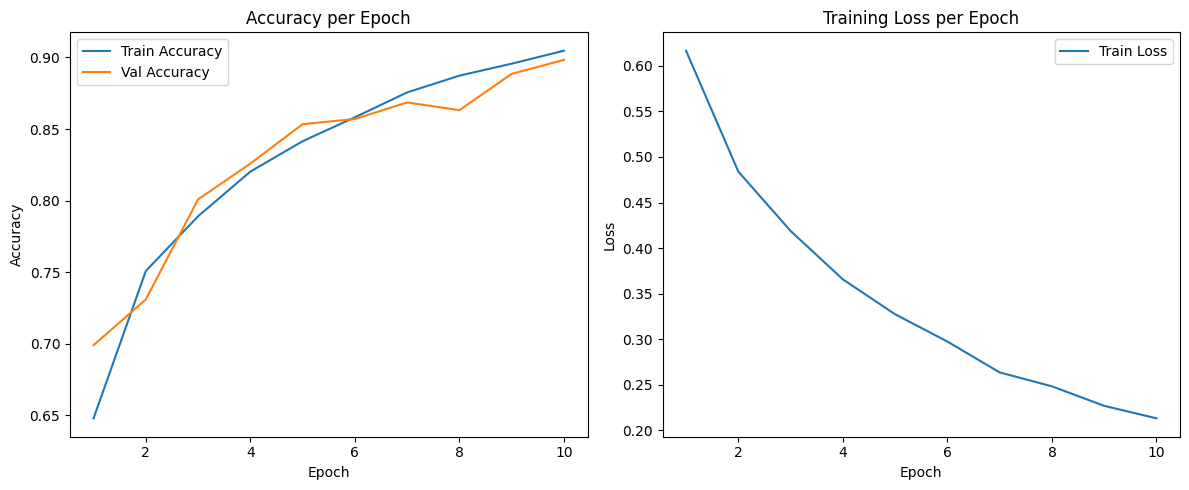

In [ ]:
plot_metrics(best_model_train_acc, best_model_val_acc, best_model_loss)

In [24]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

def evaluate_detailed(model):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.numpy())
            y_pred.extend(preds.cpu().numpy())
    print(classification_report(y_true, y_pred, target_names=dataset.classes))
    plot_confusion_matrix(y_true, y_pred, dataset.classes)


Pretrained model evaluation:
              precision    recall  f1-score   support

        fake       0.91      0.89      0.90      2989
        real       0.90      0.92      0.91      3346

    accuracy                           0.91      6335
   macro avg       0.91      0.91      0.91      6335
weighted avg       0.91      0.91      0.91      6335



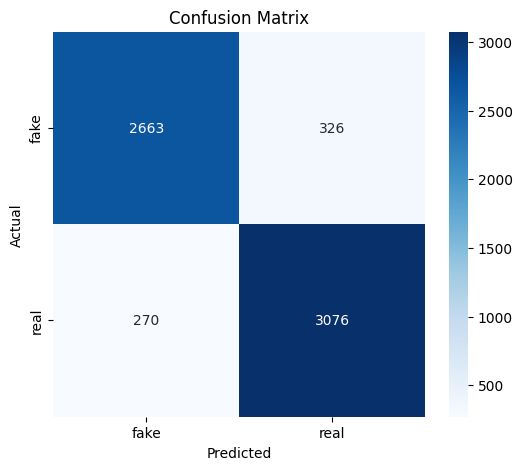

In [25]:
print("Pretrained model evaluation:")
evaluate_detailed(best_model)

Scratch model evaluation:
              precision    recall  f1-score   support

        fake       0.87      0.87      0.87      2989
        real       0.88      0.88      0.88      3346

    accuracy                           0.88      6335
   macro avg       0.88      0.88      0.88      6335
weighted avg       0.88      0.88      0.88      6335



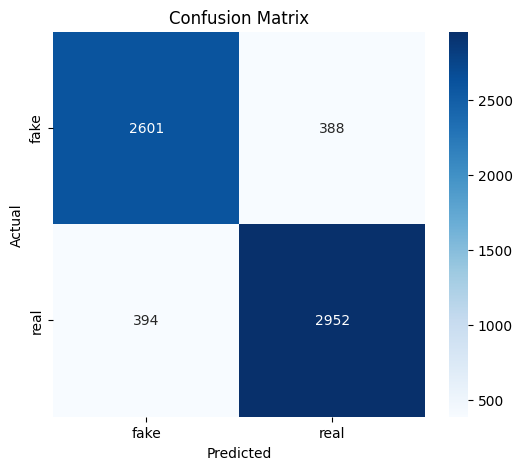

In [30]:
print("Scratch model evaluation:")
evaluate_detailed(scratch_model)

In [27]:
torch.save(best_model.state_dict(), 'pretrained_model_final.pth')

In [28]:
torch.save(scratch_model.state_dict(), 'scratch_model_final.pth')

In [ ]:
from PIL import Image

model = resnet18_scratch(num_classes=2)
model.load_state_dict(torch.load("pretrained_model_final.pth", map_location=device))
model.to(device)
model.eval()

class_names = dataset.classes  


transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

img_path = "faked.png"
img = Image.open(img_path).convert("RGB")
input_tensor = transform(img).unsqueeze(0).to(device)

with torch.no_grad():
    output = model(input_tensor)
    _, pred = torch.max(output, 1)

    probabilities = F.softmax(output, dim=1)[0]
    predicted_idx = torch.argmax(probabilities).item()
    predicted_class = class_names[predicted_idx]
    for i, name in enumerate(class_names):
        print(f"{name}: {probabilities[i].item()*100:.2f}%")
    print(f"Predicted class: {class_names[pred.item()]}")

fake: 0.04%
real: 99.96%
Predicted class: real


In [ ]:
import gradio as gr
from PIL import Image
import torch.nn.functional as F

def predict_image(img):
    if img.mode != "RGB":
        img = img.convert("RGB")
    input_tensor = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(input_tensor)
        probabilities = F.softmax(output, dim=1)[0].cpu().numpy()
        predicted_idx = probabilities.argmax()
        predicted_class = class_names[predicted_idx]
    return {name: float(probabilities[i]) for i, name in enumerate(class_names)}, predicted_class

iface = gr.Interface(
    fn=predict_image,
    inputs=gr.Image(type="pil", label="Upload Face Image"),
    outputs=[gr.Label(num_top_classes=2, label="Class Probabilities"), gr.Textbox(label="Predicted Class")],
    title="Deepfake Detection",
    description="Upload a face image to predict if it is real or fake using the trained model."
)

iface.launch()